In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from treeple.datasets import make_trunk_classification
import ydf
import matplotlib.pyplot as plt
from treeple import ObliqueRandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


# Function being used

In [2]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

In [3]:
def plot_confusion(conf_matrix):
    disp_treeple = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp_treeple.plot()
    plt.title("Confusion Matrix for Treeple Predictions vs YDF Predictions")
    plt.xlabel("treeple_pred")
    plt.ylabel("YDF_pred")
    plt.show()

In [19]:

def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train a given model and evaluate its accuracy and training time.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    if isinstance(y_pred[0], np.ndarray):  # Some models return probabilities
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name}: Accuracy = {accuracy:.4f}, Training Time = {train_time:.4f} sec")
    
    return accuracy, train_time, y_pred

In [4]:
def train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=500):
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)

    learner = ydf.RandomForestLearner(**params_ydf)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_ydf = time.time() - start_time
    y_pred = ydf_model.predict(df_test)
    y_pred_class = (y_pred >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, y_pred_class)

    print(f"YDF | n_dim: {n_dim} | n_tree: {params_ydf['num_trees']} | Accuracy: {acc_ydf:.4f} | Train Time: {time_ydf:.4f} sec")
    return acc_ydf, time_ydf, y_pred_class

In [38]:
def compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1):
    
    X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    params_treeple = params_treeple1.copy()  # Copy the original params for treeple
    params_ydf = params_ydf1.copy()  # Copy the original params for ydf
    params_treeple["n_estimators"] = n_tree
    params_ydf["num_trees"] = n_tree

    # treeple
    treeple_model = ObliqueRandomForestClassifier(**params_treeple)
    acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)

    # ydf
    acc_ydf, time_ydf, y_pred_class = train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=n_dim)


    conf_matrix_ydf = confusion_matrix(pred_treeple, y_pred_class)
    print("Confusion Matrix for YDF Predictions:")
    print(conf_matrix_ydf)
    f1_value = f1_score(y_pred_class, pred_treeple, average='weighted')
    return f1_value


In [12]:
def plot_trunk_simulation(num_dims, accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores):

    fig, ax1 = plt.subplots(1,3, figsize=(15, 5))

    # Plot accuracy
    ax1[0].plot(num_dims, accs_ydf, label='YDF Accuracy', marker='o')
    ax1[0].plot(num_dims, accs_treeple, label='Treeple Accuracy', marker='o')
    ax1[0].set_xlabel('Number of Dimensions')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_title('Accuracy vs Number of Dimensions')
    ax1[0].legend()
    ax1[0].grid(True)

    # Plot training time
    ax1[1].plot(num_dims, times_ydf, label='YDF Training Time', marker='o')
    ax1[1].plot(num_dims, times_treeple, label='Treeple Training Time', marker='o')
    ax1[1].set_xlabel('Number of Dimensions')
    ax1[1].set_ylabel('Training Time (seconds)')
    ax1[1].set_title('Training Time vs Number of Dimensions')
    ax1[1].legend()
    ax1[1].grid(True)

    # Plot training time
    ax1[2].plot(num_dims, f1_scores, label='prediction result conformity', marker='o')
    ax1[2].set_xlabel('Number of Dimensions')
    ax1[2].set_ylabel('f1 score')
    ax1[2].set_title('Prediction conformity vs Number of Dimensions')
    ax1[2].legend()
    ax1[2].grid(True)

    plt.tight_layout()
    plt.show()

make changes on num_dims, compare accuracy, running time, and conformity of prediction resutls between treeple and ydf

In [46]:
def trunk_simulation(n_tree, num_dims, n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
    #num_dims = [100, 500, 1000, 1500, 2000, 3000, 4000, 10000]
    # num_dims = [5, 10,  20, 50, 100, 200, 400, 600, 800]
    # n_trees = [100, 200, 500, 1000] 
    accs_ydf = []
    times_ydf = []
    accs_treeple = []
    times_treeple = []
    f1_scores = []
    params_treeple1 = params_treeple.copy()  # Copy the original params for treeple
    params_ydf1 = params_ydf.copy()  # Copy the original params for ydf
    params_treeple1["n_estimators"] = n_tree
    params_ydf1["num_trees"] = n_tree

    for num_dim in num_dims:
        print(f"n_dim: {num_dim} | n_tree: {n_tree} | n_samples: {n_samples}")
        

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        df_train = prepare_dataframe(X_train, y_train)
        df_test = prepare_dataframe(X_test, y_test)

        acc_temp_ydf=0
        time_temp_ydf=0

        acc_temp_treeple=0
        time_temp_treeple=0

        f1_temp=0

        for _ in range(n_rep):
            # --- Train YDF ---
            learner = ydf.RandomForestLearner(**params_ydf1)
            start_time = time.time()
            ydf_model = learner.train(df_train)
            time_ydf = time.time() - start_time
            pred_ydf = ydf_model.predict(df_test)
            pred_ydf = (pred_ydf >= 0.5).astype(int) 

            acc_ydf = accuracy_score(y_test, pred_ydf)
            acc_temp_ydf+=acc_ydf
            time_temp_ydf+=time_ydf
        
            # --- Train Treeple ---
            treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
            acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple+=acc_treeple
            time_temp_treeple+=time_treeple

            # Calculate F1 score for two predictions
            f1_compare = f1_score(pred_ydf, pred_treeple)
            f1_temp+=f1_compare

        accs_ydf.append(acc_temp_ydf/n_rep)
        times_ydf.append(time_temp_ydf/n_rep)

        accs_treeple.append(acc_temp_treeple/n_rep)
        times_treeple.append(time_temp_treeple/n_rep)

        f1_scores.append(f1_temp/n_rep)
    if plot:
        plot_trunk_simulation(num_dims, accs_ydf, times_ydf, 
                                accs_treeple, times_treeple, f1_scores)
    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores

# params setting

In [13]:
# Shared hyperparameters that used for both models
MAX_DEPTH = 10
N_ESTIMATORS = 1000
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True

### ydf ###
params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["compute_oob_performances"] = False
params_ydf["compute_oob_variable_importances"] = False
params_ydf["max_num_nodes"] = None
params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
params_ydf["num_candidate_attributes"] = 1  #0 equivalent to sqrt max_features in treeple
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["sparse_oblique_weights"] = "CONTINUOUS"
params_ydf["sparse_oblique_projection_density_factor"] = 1.0
params_ydf["sparse_oblique_normalization"] = "MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = 6000 # modify this, find in sourse code in treeple
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = None
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = 1.0 #"sqrt" #100
params_treeple["max_leaf_nodes"] = None
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = 1.0


# confusion matrix comparison

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7625, Training Time = 0.7556 sec
Train model on 1600 examples
Model trained in 0:00:00.414386
YDF | n_dim: 100 | n_tree: 100 | Accuracy: 0.7325 | Train Time: 0.4199 sec
Confusion Matrix for YDF Predictions:
[[191  18]
 [ 20 171]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7725, Training Time = 1.4266 sec
Train model on 1600 examples
Model trained in 0:00:00.780161
YDF | n_dim: 100 | n_tree: 200 | Accuracy: 0.7300 | Train Time: 0.7837 sec
Confusion Matrix for YDF Predictions:
[[188  19]
 [ 24 169]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 3.4251 sec
Train model on 1600 examples
Model trained in 0:00:01.949891
YDF | n_dim: 100 | n_tree: 500 | Accuracy: 0.7275 | Train Time: 2.1188 sec
Confusion Matrix for YDF Predictions:
[[188  18]
 [ 23 171]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 6.4855 sec
Train model on 1600 examples
Model trained in 0:00:03.718110
YDF | n_dim: 100 | n_tree: 1000 | Accuracy: 0.7300 | Train Time: 3.7221 sec
Confusion Matrix for YDF Predictions:
[[189  19]
 [ 23 169]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7775, Training Time = 9.6599 sec
Train model on 1600 examples
Model trained in 0:00:05.783666
YDF | n_dim: 100 | n_tree: 1500 | Accuracy: 0.7325 | Train Time: 5.7877 sec
Confusion Matrix for YDF Predictions:
[[188  19]
 [ 23 170]]


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 13.0074 sec
Train model on 1600 examples
Model trained in 0:00:07.558692
YDF | n_dim: 100 | n_tree: 2000 | Accuracy: 0.7325 | Train Time: 7.5647 sec
Confusion Matrix for YDF Predictions:
[[188  20]
 [ 23 169]]


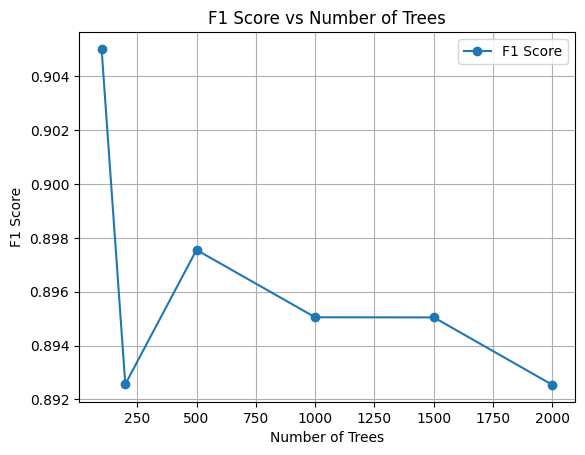

In [39]:
f1_scores = []
n_dim = 100
n_samples = 2000
n_trees = [100, 200, 500, 1000, 1500, 2000]  
for n_tree in n_trees:
    num_dims = [5, 10, 20, 50, 100, 200, 400, 600, 800]
    f1_value = compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)
    f1_scores.append(f1_value)


plt.plot(n_trees, f1_scores, marker='o', label='F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Trees')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
# compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1)
n_tree = 500
n_dim = 200
n_samples = 2000
compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8100, Training Time = 6.5569 sec
Train model on 1600 examples
Model trained in 0:00:04.203436
YDF | n_dim: 200 | n_tree: 500 | Accuracy: 0.7650 | Train Time: 4.2099 sec
Confusion Matrix for YDF Predictions:
[[179  19]
 [ 15 187]]


In [31]:
# compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1)
n_tree = 500
n_dim = 100
n_samples = 2000
compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 3.4250 sec
Train model on 1600 examples
Model trained in 0:00:01.869056
YDF | n_dim: 100 | n_tree: 500 | Accuracy: 0.7275 | Train Time: 1.8741 sec
Confusion Matrix for YDF Predictions:
[[188  18]
 [ 23 171]]


In [32]:
# compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1)
n_tree = 500
n_dim = 500
n_samples = 2000
compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 500. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7900, Training Time = 18.9392 sec
Train model on 1600 examples
Model trained in 0:00:13.657105
YDF | n_dim: 500 | n_tree: 500 | Accuracy: 0.7575 | Train Time: 13.6732 sec
Confusion Matrix for YDF Predictions:
[[191  19]
 [ 12 178]]


# trunk simulation

n_dim: 10 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.362667
Treeple: Accuracy = 0.7525, Training Time = 1.1442 sec
Train model on 1600 examples
Model trained in 0:00:00.358119
Treeple: Accuracy = 0.7525, Training Time = 1.1642 sec
Train model on 1600 examples
Model trained in 0:00:00.358810
Treeple: Accuracy = 0.7525, Training Time = 1.1420 sec
n_dim: 20 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.725282
Treeple: Accuracy = 0.7800, Training Time = 1.6366 sec
Train model on 1600 examples
Model trained in 0:00:00.697970
Treeple: Accuracy = 0.7800, Training Time = 1.6935 sec
Train model on 1600 examples
Model trained in 0:00:00.730010
Treeple: Accuracy = 0.7800, Training Time = 1.7170 sec
n_dim: 40 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.500622
Treeple: Accuracy = 0.8300, Training Time = 3.0960 sec
Train model on 1600 examples
Model trained in 0:00:01.504805
Treeple: Accuracy = 0.8300, Training Time = 3.0471 sec
Train model on 1600 examples
Model trained in 0:00:01.502982
Treeple: Accuracy = 0.8300, Training Time = 3.1651 sec
n_dim: 80 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.133011
Treeple: Accuracy = 0.8200, Training Time = 5.9501 sec
Train model on 1600 examples
Model trained in 0:00:03.228905
Treeple: Accuracy = 0.8200, Training Time = 5.8307 sec
Train model on 1600 examples
Model trained in 0:00:03.157718
Treeple: Accuracy = 0.8200, Training Time = 5.6166 sec
n_dim: 100 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:04.226278
Treeple: Accuracy = 0.7750, Training Time = 6.8888 sec
Train model on 1600 examples
Model trained in 0:00:04.261197
Treeple: Accuracy = 0.7750, Training Time = 7.4327 sec
Train model on 1600 examples
Model trained in 0:00:03.851151
Treeple: Accuracy = 0.7750, Training Time = 6.8705 sec
n_dim: 200 | n_tree: [10, 20, 40, 80, 100, 200] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:08.992781
Treeple: Accuracy = 0.8175, Training Time = 13.3619 sec
Train model on 1600 examples
Model trained in 0:00:08.646661
Treeple: Accuracy = 0.8175, Training Time = 14.1059 sec
Train model on 1600 examples
Model trained in 0:00:08.921597
Treeple: Accuracy = 0.8175, Training Time = 14.2167 sec


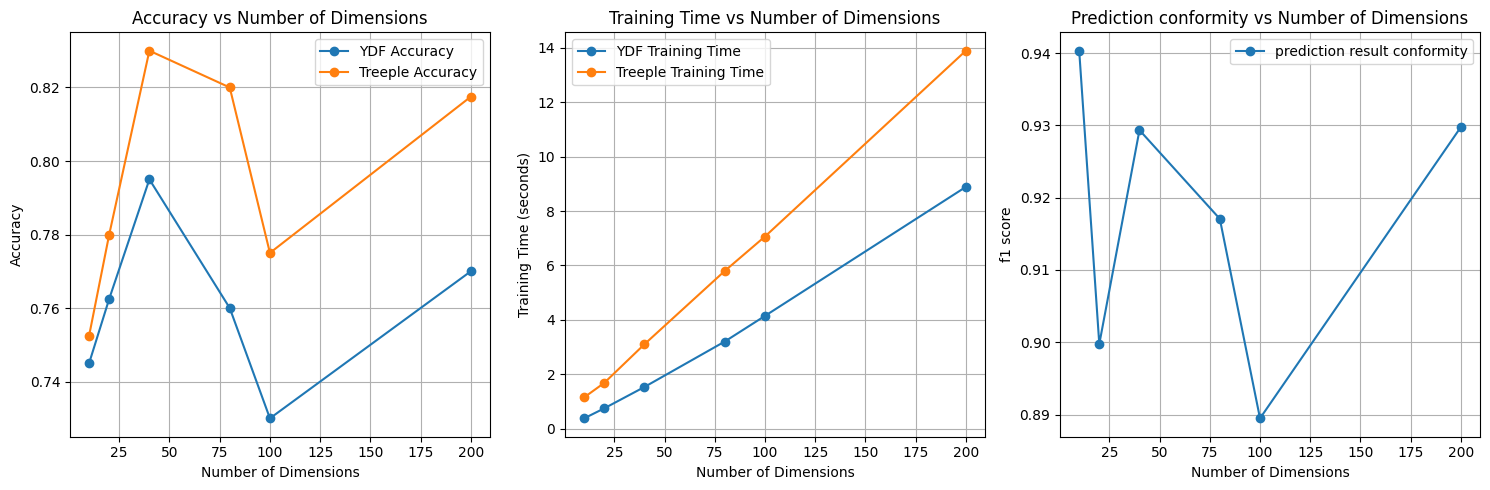

In [24]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
n_tree = 1000
num_dims = [10, 20, 40, 80, 100, 200]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(num_dims, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple, 
                                                                               params_ydf, 
                                                                               n_rep=3, 
                                                                               plot=True)

n_dim: 10 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.388251
Treeple: Accuracy = 0.7525, Training Time = 1.0997 sec
Train model on 1600 examples
Model trained in 0:00:00.359435
Treeple: Accuracy = 0.7525, Training Time = 1.1479 sec
Train model on 1600 examples
Model trained in 0:00:00.360161
Treeple: Accuracy = 0.7525, Training Time = 1.1100 sec
n_dim: 100 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.756913
Treeple: Accuracy = 0.7750, Training Time = 6.9519 sec
Train model on 1600 examples
Model trained in 0:00:03.973726
Treeple: Accuracy = 0.7750, Training Time = 6.7220 sec
Train model on 1600 examples
Model trained in 0:00:03.983926
Treeple: Accuracy = 0.7750, Training Time = 6.9089 sec
n_dim: 200 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:09.071990
Treeple: Accuracy = 0.8175, Training Time = 13.7877 sec
Train model on 1600 examples
Model trained in 0:00:08.464264
Treeple: Accuracy = 0.8175, Training Time = 14.9518 sec
Train model on 1600 examples
Model trained in 0:00:09.208511
Treeple: Accuracy = 0.8175, Training Time = 14.0900 sec
n_dim: 500 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 500. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples
Model trained in 0:00:28.235317
Treeple: Accuracy = 0.7850, Training Time = 37.4475 sec
Train model on 1600 examples
Model trained in 0:00:30.186836
Treeple: Accuracy = 0.7850, Training Time = 41.8919 sec
Train model on 1600 examples
Model trained in 0:00:28.234624
Treeple: Accuracy = 0.7850, Training Time = 39.1589 sec
n_dim: 1000 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:01:17.281569
Treeple: Accuracy = 0.7650, Training Time = 98.8450 sec
Train model on 1600 examples
Model trained in 0:01:15.845704
Treeple: Accuracy = 0.7650, Training Time = 103.4741 sec
Train model on 1600 examples
Model trained in 0:01:14.638623
Treeple: Accuracy = 0.7650, Training Time = 102.7939 sec
n_dim: 1500 | n_tree: [10, 100, 200, 500, 1000, 1500] | n_samples: 2000
Train model on 1600 examples
Model trained in 0:02:20.007052
Treeple: Accuracy = 0.7500, Training Time = 336.4375 sec
Train model on 1600 examples
Model

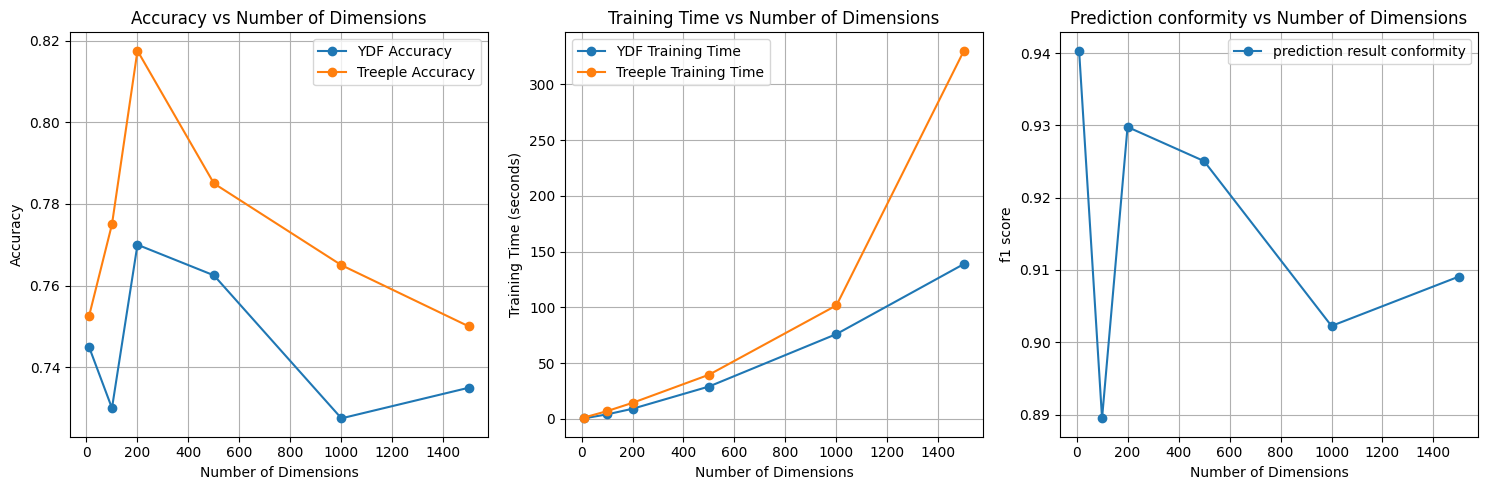

In [ ]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
n_tree = 1000
num_dims = [10, 100, 200, 500, 1000, 1500]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple, 
                                                                               params_ydf, 
                                                                               n_rep=3, 
                                                                               plot=True)

In [50]:
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = 2000

n_tree = 500
num_dims = 1500
n_samples = 2000


compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple, params_ydf1)

c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7750, Training Time = 3.2534 sec
Train model on 1600 examples
Model trained in 0:00:01.897807
YDF | n_dim: 100 | n_tree: 500 | Accuracy: 0.7275 | Train Time: 1.9018 sec
Confusion Matrix for YDF Predictions:
[[188  18]
 [ 23 171]]


0.8975545516589338

In [52]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 1000,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'split_axis': 'SPARSE_OBLIQUE',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes': 1,
 'sorting_strategy': 'IN_NODE',
 'sparse_oblique_weights': 'CONTINUOUS',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 6000,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.191650
Treeple: Accuracy = 0.7450, Training Time = 3.3116 sec
Train model on 1600 examples
Model trained in 0:00:00.178504
Treeple: Accuracy = 0.7450, Training Time = 3.4457 sec
Train model on 1600 examples
Model trained in 0:00:00.185643
Treeple: Accuracy = 0.7450, Training Time = 3.4522 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.355021
Treeple: Accuracy = 0.7775, Training Time = 3.2023 sec
Train model on 1600 examples
Model trained in 0:00:00.402785
Treeple: Accuracy = 0.7775, Training Time = 3.1709 sec
Train model on 1600 examples
Model trained in 0:00:00.360436
Treeple: Accuracy = 0.7775, Training Time = 3.1992 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.715086
Treeple: Accuracy = 0.8300, Training Time = 3.2429 sec
Train model on 1600 examples
Model trained in 0:00:00.722544
Treeple: Accuracy = 0.8300, Training Time = 3.2088 sec
Train model on 1600 examples
Model trained in 0:00:00.750248
Treeple: Accuracy = 0.8300, Training Time = 3.2118 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.168926
Treeple: Accuracy = 0.7850, Training Time = 3.4576 sec
Train model on 1600 examples
Model trained in 0:00:01.144765
Treeple: Accuracy = 0.7850, Training Time = 3.2023 sec
Train model on 1600 examples
Model trained in 0:00:01.084098
Treeple: Accuracy = 0.7850, Training Time = 3.2704 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.623464
Treeple: Accuracy = 0.8175, Training Time = 3.2907 sec
Train model on 1600 examples
Model trained in 0:00:01.484322
Treeple: Accuracy = 0.8175, Training Time = 3.4313 sec
Train model on 1600 examples
Model trained in 0:00:01.501521
Treeple: Accuracy = 0.8175, Training Time = 3.3551 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.885233
Treeple: Accuracy = 0.7750, Training Time = 3.3541 sec
Train model on 1600 examples
Model trained in 0:00:01.901786
Treeple: Accuracy = 0.7750, Training Time = 3.3664 sec
Train model on 1600 examples
Model trained in 0:00:02.033335
Treeple: Accuracy = 0.7750, Training Time = 3.3792 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.168578
Treeple: Accuracy = 0.8175, Training Time = 3.4815 sec
Train model on 1600 examples
Model trained in 0:00:02.156497
Treeple: Accuracy = 0.8175, Training Time = 3.4584 sec
Train model on 1600 examples
Model trained in 0:00:02.079698
Treeple: Accuracy = 0.8175, Training Time = 3.4487 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.499707
Treeple: Accuracy = 0.8300, Training Time = 3.8507 sec
Train model on 1600 examples
Model trained in 0:00:02.476780
Treeple: Accuracy = 0.8300, Training Time = 3.8523 sec
Train model on 1600 examples
Model trained in 0:00:02.476976
Treeple: Accuracy = 0.8300, Training Time = 3.8507 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:02.853150
Treeple: Accuracy = 0.8025, Training Time = 4.2206 sec
Train model on 1600 examples
Model trained in 0:00:02.887621
Treeple: Accuracy = 0.8025, Training Time = 4.2058 sec
Train model on 1600 examples
Model trained in 0:00:02.857379
Treeple: Accuracy = 0.8025, Training Time = 4.2167 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.274390
Treeple: Accuracy = 0.8200, Training Time = 4.5798 sec
Train model on 1600 examples
Model trained in 0:00:03.241312
Treeple: Accuracy = 0.8200, Training Time = 4.5562 sec
Train model on 

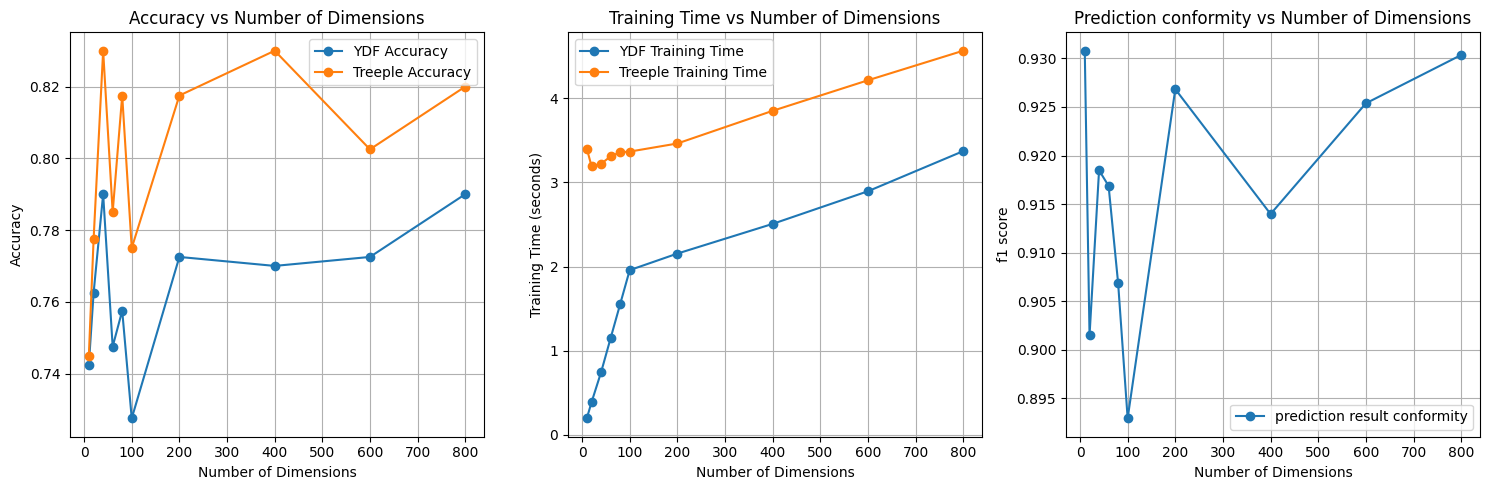

In [56]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):


params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = 100

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = 100


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=3, 
                                                                               plot=True)

In [59]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 1000,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'split_axis': 'SPARSE_OBLIQUE',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes': 1,
 'sorting_strategy': 'IN_NODE',
 'sparse_oblique_weights': 'CONTINUOUS',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 6000,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.212117


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7575, Training Time = 6.2612 sec
Train model on 1600 examples
Model trained in 0:00:00.183018
Treeple: Accuracy = 0.7575, Training Time = 6.4111 sec
Train model on 1600 examples
Model trained in 0:00:00.190011
Treeple: Accuracy = 0.7575, Training Time = 6.6756 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.354025
Treeple: Accuracy = 0.7925, Training Time = 6.0754 sec
Train model on 1600 examples
Model trained in 0:00:00.354512
Treeple: Accuracy = 0.7925, Training Time = 5.9772 sec
Train model on 1600 examples
Model trained in 0:00:00.344527
Treeple: Accuracy = 0.7925, Training Time = 6.0325 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.726553
Treeple: Accuracy = 0.8325, Training Time = 6.2157 sec
Train model on 1600 examples
Model trained in 0:00:00.723556
Treeple: Accuracy = 0.8325, Training Time = 6.0749 sec
Train model on 1600 examples
Model trained in 0:00:00.724541
Treeple: Accuracy = 0.8325, Training Time = 6.1748 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.160586
Treeple: Accuracy = 0.7775, Training Time = 6.1005 sec
Train model on 1600 examples
Model trained in 0:00:01.101589
Treeple: Accuracy = 0.7775, Training Time = 6.2256 sec
Train model on 1600 examples
Model trained in 0:00:01.099458
Treeple: Accuracy = 0.7775, Training Time = 6.2367 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.616395
Treeple: Accuracy = 0.8200, Training Time = 6.4004 sec
Train model on 1600 examples
Model trained in 0:00:01.539621
Treeple: Accuracy = 0.8200, Training Time = 6.3548 sec
Train model on 1600 examples
Model trained in 0:00:01.527098
Treeple: Accuracy = 0.8200, Training Time = 6.2548 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.868296
Treeple: Accuracy = 0.7825, Training Time = 6.3458 sec
Train model on 1600 examples
Model trained in 0:00:01.870911
Treeple: Accuracy = 0.7825, Training Time = 6.4657 sec
Train model on 1600 examples
Model trained in 0:00:01.870846
Treeple: Accuracy = 0.7825, Training Time = 6.1690 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:04.242308
Treeple: Accuracy = 0.8100, Training Time = 6.6998 sec
Train model on 1600 examples
Model trained in 0:00:04.300669
Treeple: Accuracy = 0.8100, Training Time = 6.7852 sec
Train model on 1600 examples
Model trained in 0:00:04.306234
Treeple: Accuracy = 0.8100, Training Time = 6.7571 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples
Model trained in 0:00:05.114945
Treeple: Accuracy = 0.8025, Training Time = 7.5753 sec
Train model on 1600 examples
Model trained in 0:00:05.027297
Treeple: Accuracy = 0.8025, Training Time = 7.2745 sec
Train model on 1600 examples
Model trained in 0:00:05.047914
Treeple: Accuracy = 0.8025, Training Time = 7.3348 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.696332
Treeple: Accuracy = 0.7925, Training Time = 7.9245 sec
Train model on 1600 examples
Model trained in 0:00:05.736707
Treeple: Accuracy = 0.7925, Training Time = 7.7807 sec
Train model on 1600 examples
Model trained in 0:00:05.884956
Treeple: Accuracy = 0.7925, Training Time = 7.9902 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:06.660849
Treeple: Accuracy = 0.7950, Training Time = 8.5218 sec
Train model on 1600 examples
Model trained in 0:00:06.392862
Treeple: Accuracy = 0.7950, Training Time

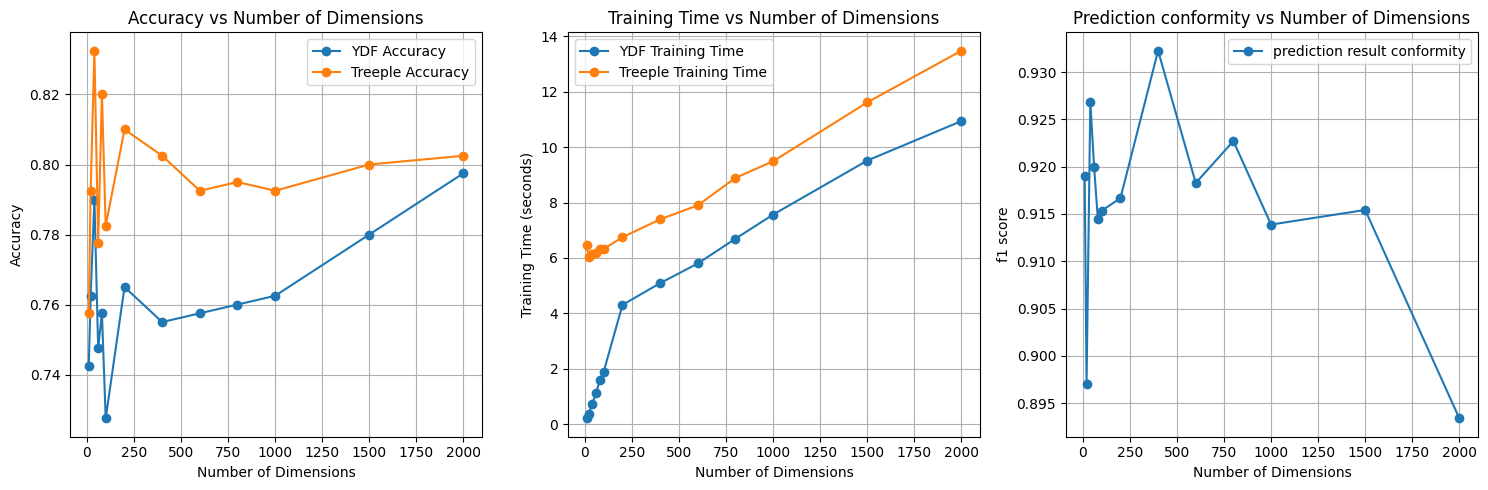

In [58]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 200
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=3, 
                                                                               plot=True)

In [66]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 1000,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'split_axis': 'SPARSE_OBLIQUE',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'max_num_nodes': None,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes': 1,
 'sorting_strategy': 'IN_NODE',
 'sparse_oblique_weights': 'CONTINUOUS',
 'sparse_oblique_projection_density_factor': 1.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 6000,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.225563
Treeple: Accuracy = 0.7450, Training Time = 3.3613 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.395850
Treeple: Accuracy = 0.7775, Training Time = 3.2178 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.752492
Treeple: Accuracy = 0.8300, Training Time = 3.1271 sec
n_dim: 60 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 60. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.139066
Treeple: Accuracy = 0.7850, Training Time = 3.1196 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.584153
Treeple: Accuracy = 0.8175, Training Time = 3.2342 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.967614
Treeple: Accuracy = 0.7750, Training Time = 3.3180 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.251922
Treeple: Accuracy = 0.8175, Training Time = 3.5028 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples
Model trained in 0:00:02.640131
Treeple: Accuracy = 0.8300, Training Time = 3.9445 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.194577
Treeple: Accuracy = 0.8025, Training Time = 4.4915 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.568311
Treeple: Accuracy = 0.8200, Training Time = 4.9353 sec
n_dim: 1000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.961640
Treeple: Accuracy = 0.7875, Training Time = 5.0526 sec
n_dim: 1500 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.685980
Treeple: Accuracy = 0.8175, Training Time = 5.8665 sec
n_dim: 2000 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.704060
Treeple: Accuracy = 0.8100, Training Time = 7.0520 sec
n_dim: 2500 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained

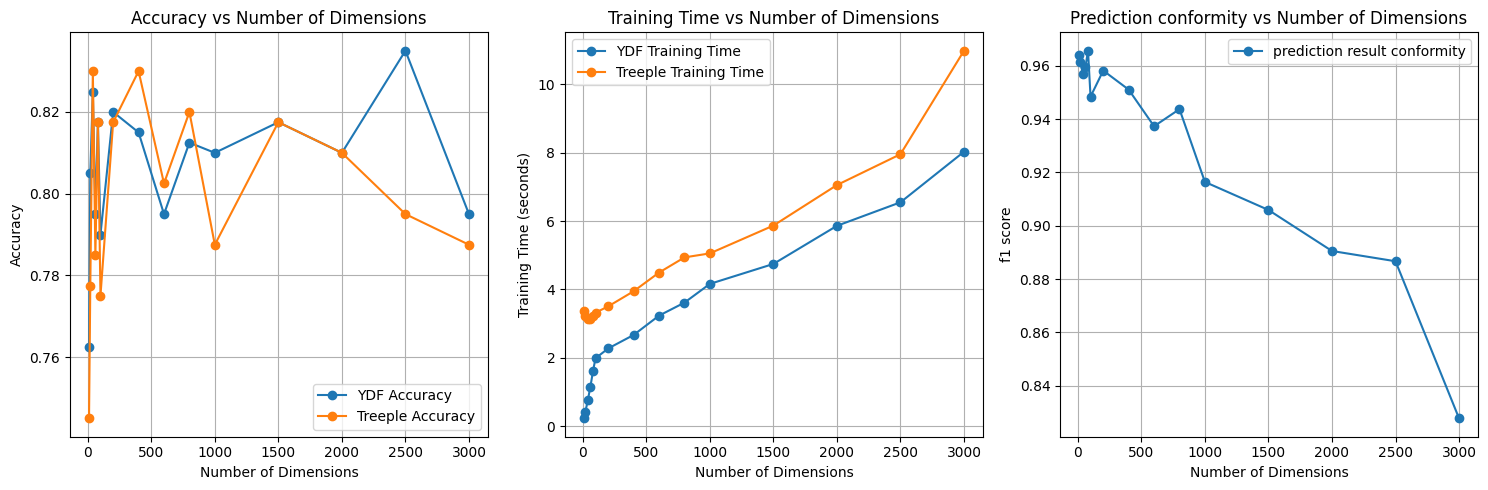

In [73]:
# trunk_simulation(n_tree, num_dims, 
#       n_samples, params_treeple, params_ydf, n_rep=5, plot=True):

MAX_FEATURES = 100
params_ydf1 = params_ydf.copy()
params_ydf1["sparse_oblique_max_num_projections"] = MAX_FEATURES
params_ydf1["sparse_oblique_num_projections_exponent"] = 1.0
params_ydf1["sparse_oblique_projection_density_factor"] = 4.0

params_treeple1 = params_treeple.copy() 
params_treeple1["max_features"] = MAX_FEATURES


n_tree = 500
num_dims = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 1500, 2000, 2500, 3000]
n_samples = 2000
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple1, 
                                                                               params_ydf1, 
                                                                               n_rep=1, 
                                                                               plot=True)